### Walmart Sales Forecasting - Using ARIMA

In [96]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

#### Data Preprocessing

In [97]:
# importing the dataset

df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [98]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [99]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst = True)
df = df.drop_duplicates(subset='Date', keep='first')
df.set_index('Date',inplace= True)
df = df.resample('W-FRI').sum()
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


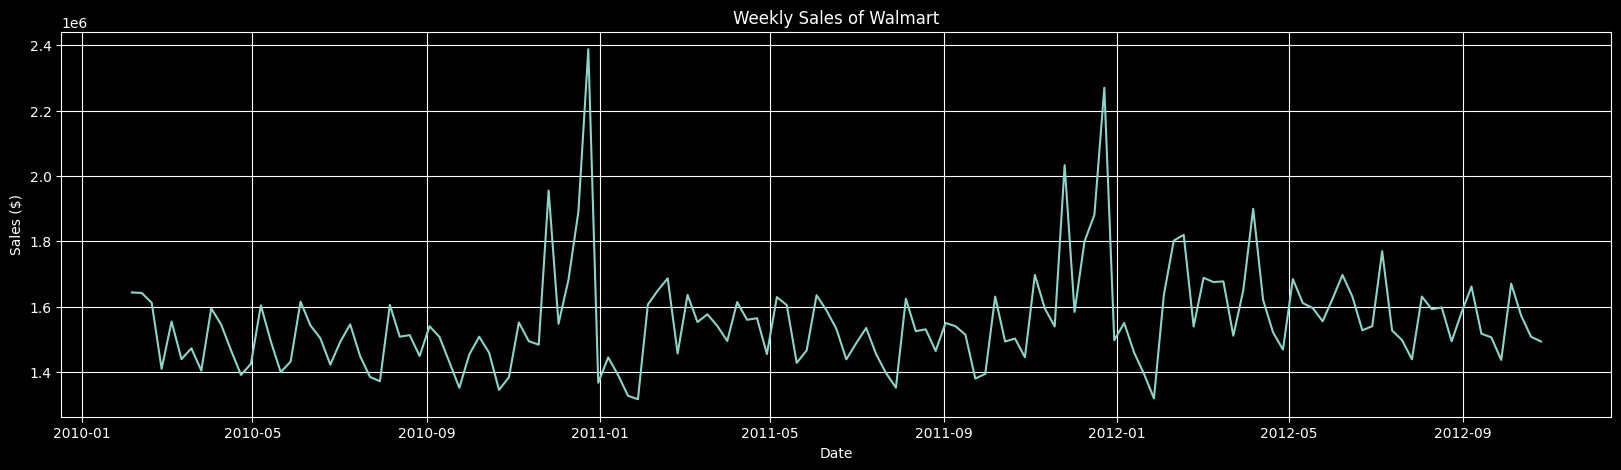

In [100]:
# plotting Weekly sales

plt.figure(figsize=(20,5))
plt.plot(df['Weekly_Sales'], label = 'Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.title('Weekly Sales of Walmart')
plt.grid()
plt.show()

#### Seasonality test

<Figure size 2000x500 with 0 Axes>

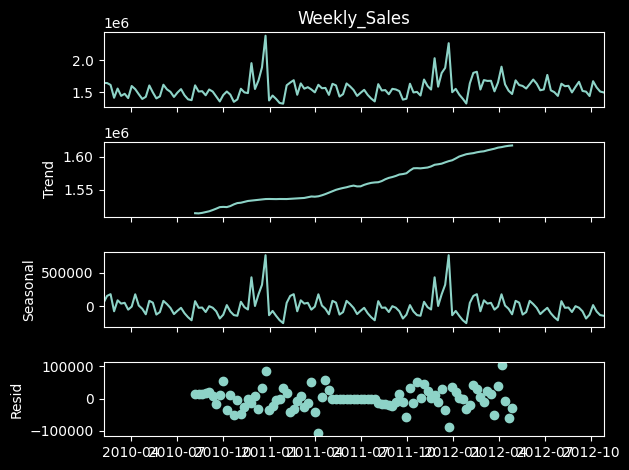

In [101]:
# seasonality check

from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(20,5))
snl = seasonal_decompose(df['Weekly_Sales'])
snl.plot()
plt.show()

#### Stationarity test

In [102]:
# stationarity check

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print('Dickey Fuller test results')
    adf = adfuller(timeseries,autolag ='AIC')
    adf_output = pd.Series(adf[0:4],index = ['Test Statistics','p-value','No of lags','No of Observations'])
    for key,value in adf[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print(adf_output)

In [103]:
adf_test(df['Weekly_Sales'])

Dickey Fuller test results
Test Statistics          -5.102186
p-value                   0.000014
No of lags                4.000000
No of Observations      138.000000
Critical Value (1%)      -3.478648
Critical Value (5%)      -2.882722
Critical Value (10%)     -2.578065
dtype: float64


p < 0.05 . Therefore, the time series is stationary.

In [104]:
# if p > 0.05, differencing is required. In that case use the following code for differencing.

#df['Sales_Diff'] = df['Weekly_Sales'].diff().dropna()
#result_diff = adfuller(df['Sales_Diff'].dropna())
#print(f"ADF after differencing: {result_diff[1]}")

In [105]:
# splitting training and test data

train_size = int(len(df)*0.8)
test_size = len(df) - train_size

df_train = df[:train_size]
df_test = df[train_size:]

#### Identifying SARIMA Orders [p,d,q][P,D,Q,s] using ACF and PACF plots

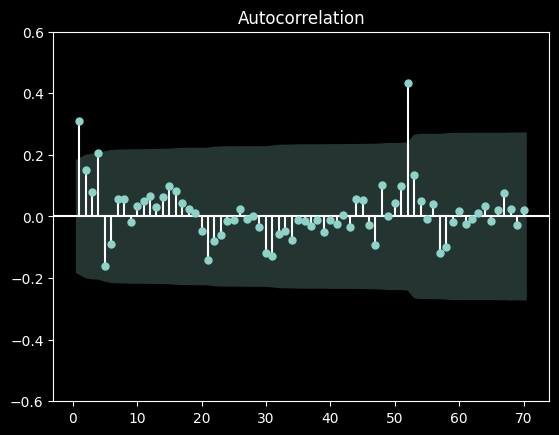

In [106]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

# acf plot

plot_acf(df_train['Weekly_Sales'],lags=70,zero=False)
plt.ylim(-0.6,0.6)
plt.show()

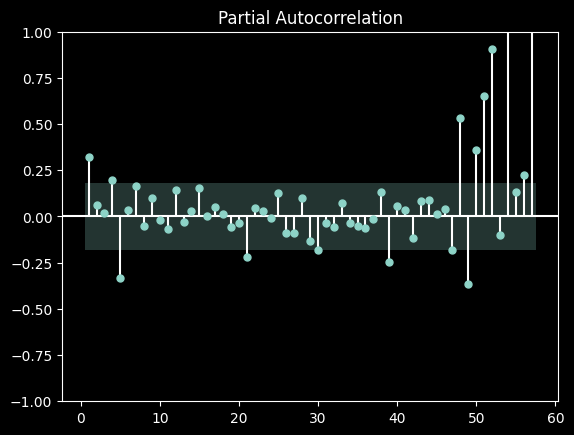

In [107]:
plot_pacf(df_train['Weekly_Sales'],lags=57,zero=False, method  = 'ols')
plt.ylim(-1,1)
plt.show()

In [108]:
# Grid Search

import itertools

# Non-seasonal orders
p = range(0, 2)  # AR order (try 0 to 2)
d = range(0, 1)  # Differencing (0 or 1)
q = range(0, 2)  # MA order (try 0 to 2)

# Seasonal orders (assuming weekly data with yearly seasonality)
P = range(0, 2)  # Seasonal AR
D = range(0, 2)  # Seasonal differencing
Q = range(0, 2)  # Seasonal MA
S = 52           # Weekly data → yearly seasonality (52 weeks)

# Generate all combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [S]))

In [109]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")  # Suppress convergence warnings

best_aic = float("inf")
best_order = None
best_seasonal_order = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(
                df_train['Weekly_Sales'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False
            )
            results = model.fit(disp=False)
            
            # Compare AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                
            print(f"SARIMA{order}x{seasonal_order} - AIC:{results.aic:.2f}")
            
        except:
            continue

print("\nBest SARIMA Model:")
print(f"Order: {best_order}")
print(f"Seasonal Order: {best_seasonal_order}")
print(f"AIC: {best_aic:.2f}")

SARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC:3545.42
SARIMA(0, 0, 0)x(0, 0, 1, 52) - AIC:2387.56
SARIMA(0, 0, 0)x(0, 1, 0, 52) - AIC:1579.58
SARIMA(0, 0, 0)x(0, 1, 1, 52) - AIC:260.89
SARIMA(0, 0, 0)x(1, 0, 0, 52) - AIC:1561.97
SARIMA(0, 0, 0)x(1, 0, 1, 52) - AIC:1595.29
SARIMA(0, 0, 0)x(1, 1, 0, 52) - AIC:267.21
SARIMA(0, 0, 0)x(1, 1, 1, 52) - AIC:235.27
SARIMA(0, 0, 1)x(0, 0, 0, 52) - AIC:3440.44
SARIMA(0, 0, 1)x(0, 0, 1, 52) - AIC:1831.39
SARIMA(0, 0, 1)x(0, 1, 0, 52) - AIC:1529.81
SARIMA(0, 0, 1)x(0, 1, 1, 52) - AIC:212.25
SARIMA(0, 0, 1)x(1, 0, 0, 52) - AIC:1888.16
SARIMA(0, 0, 1)x(1, 0, 1, 52) - AIC:1829.44
SARIMA(0, 0, 1)x(1, 1, 0, 52) - AIC:263.10
SARIMA(0, 0, 1)x(1, 1, 1, 52) - AIC:211.14
SARIMA(1, 0, 0)x(0, 0, 0, 52) - AIC:3079.18
SARIMA(1, 0, 0)x(0, 0, 1, 52) - AIC:1618.11
SARIMA(1, 0, 0)x(0, 1, 0, 52) - AIC:1548.26
SARIMA(1, 0, 0)x(0, 1, 1, 52) - AIC:240.69
SARIMA(1, 0, 0)x(1, 0, 0, 52) - AIC:1614.95
SARIMA(1, 0, 0)x(1, 0, 1, 52) - AIC:1616.69
SARIMA(1, 0, 0)x(1, 1, 0, 52) - AIC:240

#### Training SARIMA model

In [110]:
model = SARIMAX(
    df_train['Weekly_Sales'],
    order = (0,0,1),
    seasonal_order= (1,1,1,52),
    enforce_stationarity= False
)

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -101.570
Date:                            Sun, 01 Jun 2025   AIC                            211.140
Time:                                    23:45:18   BIC                            211.457
Sample:                                02-05-2010   HQIC                           208.996
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7539      0.348      2.165      0.030       0.071       1.436
ar.S.L52       0.4938      0.161   

#### Model Validation

In [111]:
# Forecast on test data
forecast_test = results.get_forecast(steps=test_size)
forecast_mean_test = forecast_test.predicted_mean
conf_int_test = forecast_test.conf_int()


In [112]:
# Calculate metrics

from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(df_test['Weekly_Sales'], forecast_mean_test)
rmse = mean_squared_error(df_test['Weekly_Sales'], forecast_mean_test, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 55601.96
RMSE: 70736.71


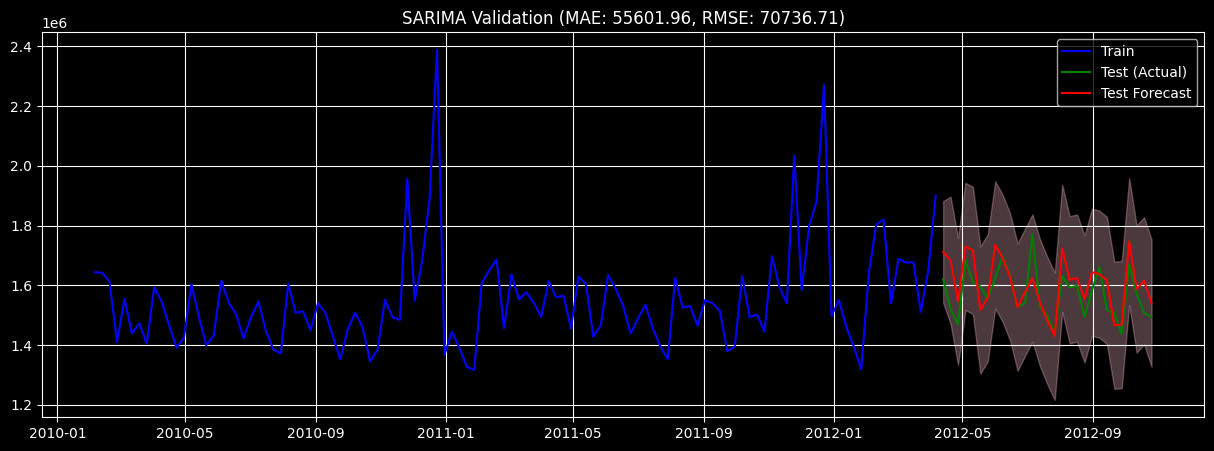

In [113]:
# Plot validation
plt.figure(figsize=(15, 5))
plt.plot(df_train.index, df_train['Weekly_Sales'], label='Train', color='blue')
plt.plot(df_test.index, df_test['Weekly_Sales'], label='Test (Actual)', color='green')
plt.plot(forecast_mean_test.index, forecast_mean_test, label='Test Forecast', color='red')
plt.fill_between(conf_int_test.index, conf_int_test.iloc[:, 0], conf_int_test.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f"SARIMA Validation (MAE: {mae:.2f}, RMSE: {rmse:.2f})")
plt.legend()
plt.grid()
plt.show()

#### Forecast

In [114]:
model = SARIMAX(
    df['Weekly_Sales'],
    order = (0,0,1),
    seasonal_order= (1,1,1,52),
    enforce_stationarity= False
)

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -465.410
Date:                            Sun, 01 Jun 2025   AIC                            938.820
Time:                                    23:45:42   BIC                            945.264
Sample:                                02-05-2010   HQIC                           941.092
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1337      0.363     -0.369      0.712      -0.845       0.578
ar.S.L52       0.9708      3.862   

In [115]:
# forecasting next 12 weeks

forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
fitted_values = results.fittedvalues # predictions for historical data

In [116]:
forecast_mean

2012-11-02    1.785489e+06
2012-11-09    1.673698e+06
2012-11-16    1.615330e+06
2012-11-23    2.133489e+06
2012-11-30    1.662035e+06
2012-12-07    1.888566e+06
2012-12-14    1.973506e+06
2012-12-21    2.381122e+06
2012-12-28    1.571578e+06
2013-01-04    1.626961e+06
2013-01-11    1.531573e+06
2013-01-18    1.463151e+06
Freq: W-FRI, Name: predicted_mean, dtype: float64

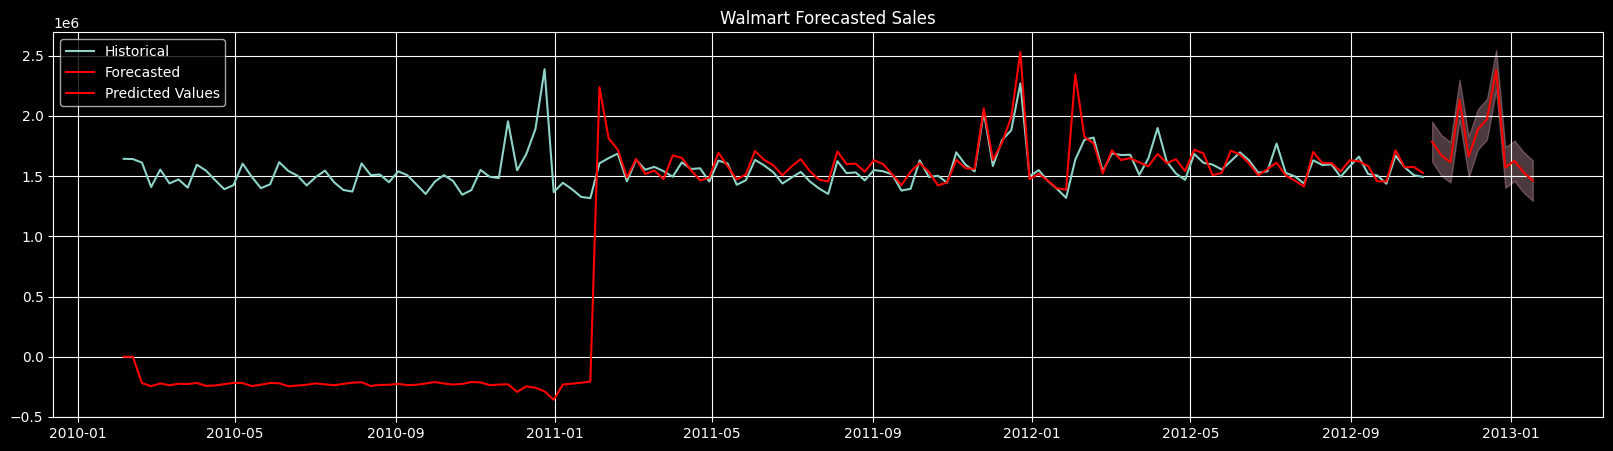

In [117]:
# plot

plt.figure(figsize=(20,5))
plt.plot(df['Weekly_Sales'], label = 'Historical')
plt.plot(forecast_mean.index , forecast_mean,label = 'Forecasted', color = 'red')
plt.plot(fitted_values.index, fitted_values, label = 'Predicted Values', color = 'red')
plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:,0],
    confidence_intervals.iloc[:,1],
    color = 'pink',
    alpha = 0.3
)

plt.title('Walmart Forecasted Sales')
plt.legend()
plt.grid()
plt.show()